In [1]:
import pandas as pd

In [2]:
import taxoniq

In [104]:
import requests

In [108]:
from io import StringIO

## Load mapping file

In [3]:
mapping = pd.read_csv('uniprot_mapping.tsv', sep='~')

0: UniProt ID
1: organism(s)
2: source database(s)

In [12]:
def get_uniprot_ids(x):
    return x.split('\t')[0]

In [52]:
def get_organisms(x):
    organisms = x.split('\t')[1].split('organism: ')[1]
    organisms_l = {o.strip() for o in organisms.split(';')}
    organisms_l2 = {o.split(' (')[0] if '(' in o else o for o in organisms_l}
    return ";".join(list(organisms_l2))

In [53]:
def get_dbs(x):
    dbs = x.split('\t')[2].split('databases: ')[1]
    dbs_l = {db.strip() for db in dbs.split(';')}
    return ";".join(list(dbs_l))

In [16]:
mapping['uniprot_ids'] = mapping['record_description'].apply(lambda x: get_uniprot_ids(x))

In [54]:
mapping['organisms'] = mapping['record_description'].apply(lambda x: get_organisms(x))

In [55]:
mapping['source_dbs'] = mapping['record_description'].apply(lambda x: get_dbs(x))

Almost half of sequences from UniParc do not originate from UniProt -> they should maybe get their UPIs 

In [56]:
mapping[mapping['record_id'] == 'NoUniProtID'].shape[0]/mapping.shape[0]

0.43141049245868623

In [57]:
mapping

,record_id,record_description,new_id,uniprot_ids,organisms,source_dbs
0,O59947;,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,uniprot_000000,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,Stachybotrys chartarum IBT 40288;Stachybotrys ...,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EMBL_CON;TR...
1,Q84LE3,Q84LE3\torganism: Lotus japonicus; Lotus japon...,uniprot_000001,Q84LE3,Lotus japonicus;Lotus corniculatus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF
2,Q84PE2,Q84PE2\torganism: Lotus japonicus; Lotus japon...,uniprot_000002,Q84PE2,Lotus japonicus,EMBL;UniProtKB/TrEMBL;USPTO;TREMBLNEW;PRF
3,Q84PE1,Q84PE1\torganism: Lotus japonicus; Lotus japon...,uniprot_000003,Q84PE1,Lotus japonicus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF
4,P13513;,P13513; Q7LP67.1 (obsolete)\torganism: Fusariu...,uniprot_000004,P13513; Q7LP67.1 (obsolete),Fusarium sporotrichioides,PIRARC;EMBL;UniProtKB/TrEMBL;PDB;TREMBLNEW;PRF...
...,...,...,...,...,...,...
266129,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266129,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS
266130,NoUniProtID,NoUniProtID\torganism: Streptomyces sp. CMSTAA...,uniprot_266130,NoUniProtID,Streptomyces sp. CMSTAAHL-2,RefSeq
266131,NoUniProtID,NoUniProtID\torganism: Agrobacterium; Agrobact...,uniprot_266131,NoUniProtID,Agrobacterium;Agrobacterium salinitolerans,RefSeq;EMBLWGS
266132,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266132,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS


In [58]:
mapping.to_csv('uniprot_mapping_annotated.csv')

## Add more information from UniProt

In [91]:
uniprot_ids = mapping['uniprot_ids'].tolist()

In [95]:
uniprot_ids2 = []
for ids_str in uniprot_ids:
    uniprot_ids2.extend(ids_str.split(';'))

In [99]:
uniprot_ids3 = []
for uni_id in uniprot_ids2:
    if (not 'obsolete' in uni_id) and (uni_id != 'NoUniProtID'):
        uniprot_ids3.append(uni_id.strip())

In [101]:
len(uniprot_ids3)

146855

In [88]:
base_url='https://rest.uniprot.org/uniprot/search?fields=accession,id,gene_names,protein_name,protein_families,organism_name,organism_id,fragment,ft_act_site,cc_catalytic_activity,ec,cc_function,rhea,ft_site&format=tsv&query=%22'

In [109]:
data_l = []
for i in range(0, len(uniprot_ids3)+1, 25):
    ids_chunk = uniprot_ids3[i:i+25]
    ids_query = '%22OR%22'.join(ids_chunk)
    url = f"{base_url}{ids_query}%22"
    result = requests.get(url)
    if result.ok:
        data= result.text
        data_l.append(pd.read_csv(StringIO(data), sep='\t'))
    else:
        print(i)
        print(ids_chunk)
        print('Something went wrong ', result.status_code)
        exit(1)

In [111]:
uniprot_df = pd.concat(data_l)

In [119]:
uniprot_df

,Entry,Entry Name,Gene Names,Protein names,Protein families,Organism,Organism (ID),Fragment,Active site,Catalytic activity,EC number,Function [CC],Rhea ID,Site
0,P38605,CAS1_ARATH,CAS1 CYC At2g07050 T4E14.16,Cycloartenol synthase (AtCYC) (EC 5.4.99.8) (2...,Terpene cyclase/mutase family,Arabidopsis thaliana (Mouse-ear cress),3702.0,NaN,"ACT_SITE 483; /note=""Proton donor""; /evidence=...","CATALYTIC ACTIVITY: Reaction=(S)-2,3-epoxysqua...",5.4.99.8,FUNCTION: Converts oxidosqualene to cycloarten...,RHEA:21308,NaN
1,P53799,FDFT1_ARATH,SQS1 At4g34640 T4L20.220,Squalene synthase 1 (SQS 1) (SS 1) (EC 2.5.1.2...,Phytoene/squalene synthase family,Arabidopsis thaliana (Mouse-ear cress),3702.0,NaN,NaN,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E)-farnesy...",2.5.1.21,NaN,RHEA:32295 RHEA:32299,NaN
2,Q84KL6,PT1_PINTA,PT1,"(-)-alpha-pinene synthase, chloroplastic (EC 4...","Terpene synthase family, Tpsd subfamily",Pinus taeda (Loblolly pine),3352.0,NaN,NaN,CATALYTIC ACTIVITY: Reaction=(2E)-geranyl diph...,4.2.3.119,FUNCTION: Involved in defensive oleoresin form...,RHEA:25488,NaN
3,P13513,TRI5_FUSSP,TRI5 TOX 5,Trichodiene synthase (EC 4.2.3.6) (Core tricho...,Trichodiene synthase family,Fusarium sporotrichioides,5514.0,NaN,NaN,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6,FUNCTION: Trichodiene synthase; part of the co...,RHEA:12052,NaN
4,Q84KL3,PT30_PINTA,PT30,"(+)-alpha-pinene synthase, chloroplastic (EC 4...","Terpene synthase family, Tpsd subfamily",Pinus taeda (Loblolly pine),3352.0,NaN,NaN,CATALYTIC ACTIVITY: Reaction=(2E)-geranyl diph...,4.2.3.121,FUNCTION: Involved in defensive oleoresin form...,RHEA:32575,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,A0A9E9L8B6,A0A9E9L8B6_9BURK,NB647_01390,Polyprenyl synthetase family protein,FPP/GGPP synthase family,Oxalobacter aliiformigenes,2946593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A9E9LCB4,A0A9E9LCB4_9BURK,NB646_01775,Polyprenyl synthetase family protein,FPP/GGPP synthase family,Oxalobacter aliiformigenes,2946593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A9E9MLV7,A0A9E9MLV7_9ACTN,M6B22_00945,Polyprenyl synthetase family protein,FPP/GGPP synthase family,Jatrophihabitans sp. SB3-54,2944128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A9E9MPN2,A0A9E9MPN2_9ACTN,M6B22_09920,Polyprenyl synthetase family protein,FPP/GGPP synthase family,Jatrophihabitans sp. SB3-54,2944128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Test adding info

In [139]:
# Sample DataFrames
data1 = {'IDs': ['1a;2a;3a', '4a;5a', '6a']}
data2 = {'ID': ['1a', '2a', '3a', '5a'], 'name': ['A', 'B', 'C', 'D'], 'function': ['Func1', 'Func2', 'Func3', 'Func5'], 'organism': ['Org1', 'Org2', 'Org3', 'Org5']}

In [140]:
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [169]:
df1

,IDs
0,1a;2a;3a
1,4a;5a
2,6a


In [170]:
df2

,ID,name,function,organism
0,1a,A,Func1,Org1
1,2a,B,Func2,Org2
2,3a,C,Func3,Org3
3,5a,D,Func5,Org5


In [184]:
df1_anno = {}
df2_ids = df2['ID'].tolist()
for ids in df1['IDs'].tolist():
    print(ids)
    anno_l = []
    for entry_id in ids.split(';'):
        if entry_id in df2_ids:
            #print(entry_id)
            anno_l.append(df2[df2['ID'] == entry_id].values.tolist()[0])
    ids = ';'.join([l[0] for l in anno_l])
    names = ';'.join([l[1] for l in anno_l])
    functions = ';'.join([l[2] for l in anno_l])
    organisms = ';'.join([l[3] for l in anno_l])
    df1_anno[ids] = [ids, names, functions, organisms]

1a;2a;3a
4a;5a
6a


In [190]:
pd.DataFrame.from_dict(df1_anno, orient='index', columns=['ids', 'names','functions','organisms'])

,ids,names,functions,organisms
1a;2a;3a,1a;2a;3a,A;B;C,Func1;Func2;Func3,Org1;Org2;Org3
4a;5a,4a;5a,D,Func5,Org5
6a,6a,,,


### Adding info

In [194]:
mapping['uniprot_ids'].tolist()[0].split('; ')

['O59947',
 'Q71RX9',
 'A0A084R4B7',
 'O59947.1 (obsolete)',
 'A0A084P550.1 (obsolete)']

In [195]:
uniprot_df.columns

Index(['Entry', 'Entry Name', 'Gene Names', 'Protein names',
       'Protein families', 'Organism', 'Organism (ID)', 'Fragment',
       'Active site', 'Catalytic activity', 'EC number', 'Function [CC]',
       'Rhea ID', 'Site'],
      dtype='object')

In [204]:
mapping_anno = {}
uniprot_df_ids = uniprot_df['Entry'].tolist()
for ids in mapping['uniprot_ids'].tolist():
    anno_l = []
    for entry_id in ids.split('; '):
        if entry_id in uniprot_df_ids:
            anno_l.append(uniprot_df[uniprot_df['Entry'] == entry_id].values.tolist()[0])
    entry_names = ';'.join([l[1] for l in anno_l])
    gene_names = ';'.join([str(l[2]) for l in anno_l])
    protein_names = ';'.join([l[3] for l in anno_l])
    protein_families = ';'.join([str(l[4]) for l in anno_l])
    organisms = ';'.join([str(l[5]) for l in anno_l])
    organisms_taxids = ';'.join([str(l[6]) for l in anno_l])
    fragments = ';'.join([str(l[7]) for l in anno_l])
    active_sites = ';'.join([str(l[8]) for l in anno_l])
    catalytic_activities = ';'.join([str(l[9]) for l in anno_l])
    ec_numbers = ';'.join([str(l[10]) for l in anno_l])
    functions = ';'.join([str(l[11]) for l in anno_l])
    rheas = ';'.join([str(l[12]) for l in anno_l])
    sites = ';'.join([str(l[13]) for l in anno_l])

    mapping_anno[ids] = [entry_names, gene_names, protein_names, protein_families, organisms, organisms_taxids, fragments, active_sites, catalytic_activities, ec_numbers, functions, rheas, sites]

In [211]:
uniprot_extra_anno = pd.DataFrame.from_dict(mapping_anno, orient='index', columns=['entry_names', 'gene_names', 'protein_names', 'protein_families', 'organisms', 'organisms_taxids', 'fragments', 'active_sites', 'catalytic_activities', 'ec_numbers', 'functions', 'rheas', 'sites'])

In [214]:
#uniprot_extra_anno = uniprot_extra_anno.drop(uniprot_extra_anno.index[:3])

In [216]:
uniprot_extra_anno.head(20)

,entry_names,gene_names,protein_names,protein_families,organisms,organisms_taxids,fragments,active_sites,catalytic_activities,ec_numbers,functions,rheas,sites
O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete); A0A084P550.1 (obsolete),TRI5_STACH;Q71RX9_STACH;A0A084R4B7_STACH,TRI5;TRI5;TRI5 S40288_05530,Trichodiene synthase (EC 4.2.3.6) (Sesquiterpe...,Trichodiene synthase family;Trichodiene syntha...,Stachybotrys chartarum (Toxic black mold) (Sti...,74722.0;74722.0;1283842.0,nan;nan;nan,nan;nan;nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6;4.2.3.6;4.2.3.6,FUNCTION: TS is a member of the terpene cyclas...,RHEA:12052;RHEA:12052;RHEA:12052,nan;nan;nan
Q84LE3,Q84LE3_LOTJA,LjSqS,Squalene synthase (EC 2.5.1.21),Phytoene/squalene synthase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E)-farnesy...",2.5.1.21,FUNCTION: Catalyzes the condensation of 2 farn...,RHEA:32299 RHEA:32295,nan
Q84PE2,Q84PE2_LOTJA,AMY1,Terpene cyclase/mutase family member (EC 5.4.9...,Terpene cyclase/mutase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,fragment,nan,nan,5.4.99.-,nan,nan,nan
Q84PE1,Q84PE1_LOTJA,AMY2,Terpene cyclase/mutase family member (EC 5.4.9...,Terpene cyclase/mutase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,nan,nan,nan,5.4.99.-,nan,nan,nan
P13513; Q7LP67.1 (obsolete),TRI5_FUSSP,TRI5 TOX 5,Trichodiene synthase (EC 4.2.3.6) (Core tricho...,Trichodiene synthase family,Fusarium sporotrichioides,5514.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6,FUNCTION: Trichodiene synthase; part of the co...,RHEA:12052,nan
P53799; A0A5S9XYM7; A0A654FVH2.1 (obsolete),FDFT1_ARATH;A0A5S9XYM7_ARATH,SQS1 At4g34640 T4L20.220;AN1_LOCUS20305 AT9943...,Squalene synthase 1 (SQS 1) (SS 1) (EC 2.5.1.2...,Phytoene/squalene synthase family;Phytoene/squ...,Arabidopsis thaliana (Mouse-ear cress);Arabido...,3702.0;3702.0,nan;nan,nan;nan,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E)-farnesy...",2.5.1.21;2.5.1.21,nan;FUNCTION: Catalyzes the condensation of 2 ...,RHEA:32295 RHEA:32299;RHEA:32299 RHEA:32295,nan;nan
P21683; D4GFK9; G7UMT4.1 (obsolete); G9AY33.1 (obsolete); U4WEY5.1 (obsolete); A0A0B8M1V9.1 (obsolete); A0A0E9BCQ1.1 (obsolete); A0A0N1S1B1.1 (obsolete); A0A221NDR8.1 (obsolete); A0A225T3K4.1 (obsolete); A0A2V2XWF3.1 (obsolete),CRTB_PANAN;D4GFK9_PANAM,crtB;crtB PANA_4162,15-cis-phytoene synthase (PSase) (EC 2.5.1.32)...,Phytoene/squalene synthase family;nan,Pantoea ananas (Erwinia uredovora);Pantoea ana...,553.0;706191.0,nan;nan,nan;nan,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E,10E)-ger...",2.5.1.32;nan,FUNCTION: Involved in the biosynthesis of caro...,RHEA:34475;nan,nan;nan
Q7KWU0; Q8T270.1 (obsolete); Q86KM5.1 (obsolete); Q7KWU0.1 (obsolete); Q559I1.1 (obsolete),TPS2_DICDI,TPS2 DDB0168859,Terpene synthase 2 (EC 4.2.3.-) (EC 4.2.3.161),Terpene synthase family,Dictyostelium discoideum (Social amoeba),44689.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.-; 4.2.3.161,FUNCTION: Terpene synthase that converts its s...,RHEA:53632 RHEA:68824 RHEA:68708,nan
Q75J90; Q86JQ2.1 (obsolete); Q75J90.1 (obsolete); Q54ZR0.1 (obsolete),TPS4_DICDI,TPS4 DDB0169193,Terpene synthase 4 (EC 4.2.3.-),Terpene synthase family,Dictyostelium discoideum (Social amoeba),44689.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.-,FUNCTION: Terpene synthase that converts its s...,RHEA:56984,nan
Q84KL6; Q84KL6.1 (obsolete),PT1_PINTA,PT1,"(-)-alpha-pinene synthase, chloroplastic (EC 4...","Terpene synthase family, Tpsd subfamily",Pinus taeda (Loblolly pine),3352.0,nan,nan,CATALYTIC ACTIVITY: Reaction=(2E)-geranyl diph...,4.2.3.119,FUNCTION: Involved in defensive oleoresin form...,RHEA:25488,nan


In [217]:
uniprot_extra_anno.to_csv('uniprot_extra_anno.csv')

In [236]:
anno_df = pd.read_csv('uniprot_mapping_annotated.csv', index_col=0)

In [237]:
anno_df.columns

Index(['record_id', 'record_description', 'new_id', 'uniprot_ids', 'organisms',
       'source_dbs'],
      dtype='object')

In [238]:
anno_df.shape

(266134, 6)

In [239]:
uniprot_extra_anno.columns

Index(['index', 'entry_names', 'gene_names', 'protein_names',
       'protein_families', 'organisms', 'organisms_taxids', 'fragments',
       'active_sites', 'catalytic_activities', 'ec_numbers', 'functions',
       'rheas', 'sites'],
      dtype='object')

In [227]:
uniprot_extra_anno.shape

(151322, 13)

In [228]:
uniprot_extra_anno = uniprot_extra_anno.reset_index()

In [240]:
anno_df2 = anno_df.merge(uniprot_extra_anno, how='left', left_on='uniprot_ids', right_on='index')

In [241]:
anno_df2.columns

Index(['record_id', 'record_description', 'new_id', 'uniprot_ids',
       'organisms_x', 'source_dbs', 'index', 'entry_names', 'gene_names',
       'protein_names', 'protein_families', 'organisms_y', 'organisms_taxids',
       'fragments', 'active_sites', 'catalytic_activities', 'ec_numbers',
       'functions', 'rheas', 'sites'],
      dtype='object')

In [242]:
anno_df2[['organisms_x', 'organisms_y']]

,organisms_x,organisms_y
0,Stachybotrys chartarum IBT 40288;Stachybotrys ...,Stachybotrys chartarum (Toxic black mold) (Sti...
1,Lotus japonicus;Lotus corniculatus,Lotus japonicus (Lotus corniculatus var. japon...
2,Lotus japonicus,Lotus japonicus (Lotus corniculatus var. japon...
3,Lotus japonicus,Lotus japonicus (Lotus corniculatus var. japon...
4,Fusarium sporotrichioides,Fusarium sporotrichioides
...,...,...
266129,Agrobacterium leguminum,
266130,Streptomyces sp. CMSTAAHL-2,
266131,Agrobacterium;Agrobacterium salinitolerans,
266132,Agrobacterium leguminum,


## Add taxids and lineage

In [246]:
anno_df2.rename(columns={'organisms_x': 'organisms_source', 'organisms_y': 'organisms_uniprot', 'organisms_taxids': 'uniprot_tax_ids'}, inplace=True)

In [247]:
anno_df2

,record_id,record_description,new_id,uniprot_ids,organisms_source,source_dbs,index,entry_names,gene_names,protein_names,protein_families,organisms_uniprot,uniprot_tax_ids,fragments,active_sites,catalytic_activities,ec_numbers,functions,rheas,sites
0,O59947;,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,uniprot_000000,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,Stachybotrys chartarum IBT 40288;Stachybotrys ...,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EMBL_CON;TR...,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,TRI5_STACH;Q71RX9_STACH;A0A084R4B7_STACH,TRI5;TRI5;TRI5 S40288_05530,Trichodiene synthase (EC 4.2.3.6) (Sesquiterpe...,Trichodiene synthase family;Trichodiene syntha...,Stachybotrys chartarum (Toxic black mold) (Sti...,74722.0;74722.0;1283842.0,nan;nan;nan,nan;nan;nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6;4.2.3.6;4.2.3.6,FUNCTION: TS is a member of the terpene cyclas...,RHEA:12052;RHEA:12052;RHEA:12052,nan;nan;nan
1,Q84LE3,Q84LE3\torganism: Lotus japonicus; Lotus japon...,uniprot_000001,Q84LE3,Lotus japonicus;Lotus corniculatus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF,Q84LE3,Q84LE3_LOTJA,LjSqS,Squalene synthase (EC 2.5.1.21),Phytoene/squalene synthase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E)-farnesy...",2.5.1.21,FUNCTION: Catalyzes the condensation of 2 farn...,RHEA:32299 RHEA:32295,nan
2,Q84PE2,Q84PE2\torganism: Lotus japonicus; Lotus japon...,uniprot_000002,Q84PE2,Lotus japonicus,EMBL;UniProtKB/TrEMBL;USPTO;TREMBLNEW;PRF,Q84PE2,Q84PE2_LOTJA,AMY1,Terpene cyclase/mutase family member (EC 5.4.9...,Terpene cyclase/mutase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,fragment,nan,nan,5.4.99.-,nan,nan,nan
3,Q84PE1,Q84PE1\torganism: Lotus japonicus; Lotus japon...,uniprot_000003,Q84PE1,Lotus japonicus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF,Q84PE1,Q84PE1_LOTJA,AMY2,Terpene cyclase/mutase family member (EC 5.4.9...,Terpene cyclase/mutase family,Lotus japonicus (Lotus corniculatus var. japon...,34305.0,nan,nan,nan,5.4.99.-,nan,nan,nan
4,P13513;,P13513; Q7LP67.1 (obsolete)\torganism: Fusariu...,uniprot_000004,P13513; Q7LP67.1 (obsolete),Fusarium sporotrichioides,PIRARC;EMBL;UniProtKB/TrEMBL;PDB;TREMBLNEW;PRF...,P13513; Q7LP67.1 (obsolete),TRI5_FUSSP,TRI5 TOX 5,Trichodiene synthase (EC 4.2.3.6) (Core tricho...,Trichodiene synthase family,Fusarium sporotrichioides,5514.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6,FUNCTION: Trichodiene synthase; part of the co...,RHEA:12052,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266129,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266129,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS,NoUniProtID,,,,,,,,,,,,,
266130,NoUniProtID,NoUniProtID\torganism: Streptomyces sp. CMSTAA...,uniprot_266130,NoUniProtID,Streptomyces sp. CMSTAAHL-2,RefSeq,NoUniProtID,,,,,,,,,,,,,
266131,NoUniProtID,NoUniProtID\torganism: Agrobacterium; Agrobact...,uniprot_266131,NoUniProtID,Agrobacterium;Agrobacterium salinitolerans,RefSeq;EMBLWGS,NoUniProtID,,,,,,,,,,,,,
266132,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266132,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS,NoUniProtID,,,,,,,,,,,,,


In [265]:
# top 50 most abundant organisms which could not map - manually added the tax ids
taxid_map = {'Chloroflexi bacterium':2026724,
             'Acidobacteria bacterium':1978231,
             'Oryza sativa subsp. japonica':39947,
             'Firmicutes bacterium':1879010,
             'Gemmatimonadetes bacterium':2026742,
             'Rhodococcus hoagii':43767,
             'Verrucomicrobia bacterium':2026799,
             'Dioscorea cayennensis subsp. rotundata':55577,
             'Enterobacter agglomerans':549,
             'Actinomycetia bacterium':1883427,
             'Mycobacterium bovis':1765,
             'Gibberella fujikuroi':5127,
             'Prevotella copri':165179,
             'Rhizobium radiobacter':358,
             'Magnaporthe oryzae':318829,
             'Candidatus Omnitrophica bacterium':2035772,
             'Phaseolus angularis':3914,
             'Brassica campestris':145471,
             'Citrus clementina':85681,
             'Gibberella zeae':5518,
             'Armatimonadetes bacterium':2033014,
             'Nitrospirae bacterium':2026887,
             'Streptomyces sp. AA8':2720021,
             'Spirochaetes bacterium':2202144,
             'Claroideoglomus sp. SA101':2562287,
             'Borrelia garinii':29519,
             'Gibberella intermedia':948311,
             'Agrobacterium rhizogenes':359,
             'Streptomyces sp. A15ISP2-DRY2':2867268,
             'Streptomyces sp. PLAI1-29':2053010,
             'Mycobacterium heraklionense':512402,
             'Nitrospinae bacterium':2026769,
             'Streptomyces cocklensis':887465,
             'Rhizopus oryzae':64495,
             'Gibberella moniliformis':405761,
             'Bionectria ochroleuca':29856,
             'Streptomyces sp. IBSBF 2953':2839966,
             'Pelagibacter ubique':198252,
             'Phanerochaete chrysosporium':2822231,
             'Archangium sp. miwbw1':2995310,
             'Pantoea ananas':553,
             'Pichia angusta':870730,
             'Streptomyces sp. RCU064':2967341,
             'Streptomyces sp. M600PL45_2':2922868,
             'Salmonella enterica I':59201,
             'Streptomyces sp. 4503':2842201,
             'Rhizobium meliloti':382,
             'Yinghuangia sp. KLBMP8922':2908204,
             'Alcaligenes xylosoxydans xylosoxydans':85698
            }

In [266]:
def get_tax_id(x):
    try:
        # try getting taxid for every organism in the source untill success
        organisms = x['organisms_source'].split(';')
    
        for organism in organisms:
            
            # if the organism is present in the taxid map, use the corresponding taxid
            if organism in taxid_map.keys():
                return taxid_map[organism]
            try:
                t = taxoniq.Taxon(scientific_name=organism)
                return t.tax_id
            except:
                continue
        
        # if not succesfull, try every organism from uniprot untill success
        # TODO: maybe remove braces?
        organisms = x['organisms_uniprot'].split(';')
        for organism in organisms:
            # if the organism is present in the taxid map, use the corresponding taxid
            if organism in taxid_map.keys():
                return taxid_map[organism]
            try:
                t = taxoniq.Taxon(scientific_name=organism)
                return t.tax_id
            except:
                continue
        
        # if not succesfull, use the uniprot_tax_ids
        if x['uniprot_tax_ids'] != '':
            return x['uniprot_tax_ids']
        return 'error'
    except:
        return 'error'

In [285]:
def get_organism_from_tax_id(x):
    try:
        taxid = x['tax_id']
        t = taxoniq.Taxon(taxid)
        return t.scientific_name
    except:
        if type(x['organisms_source']) == str:
            return x['organisms_source']
        if type(x['organisms_uniprot']) == str:
            if x['organisms_uniprot'] == '':
                return 'unknown'
            return x['organisms_uniprot']
        return 'unknown'

In [267]:
anno_df2['tax_id'] = anno_df2.apply(lambda x: get_tax_id(x), axis=1)

In [ ]:
def get_multi_tax_ids(x):
    if type(x) == int:
        return False

In [312]:
anno_df2[anno_df2['tax_id'].apply(lambda x: False if type(x)==int else ';' in x)]

,record_id,record_description,new_id,uniprot_ids,organisms_source,source_dbs,index,entry_names,gene_names,protein_names,...,ec_numbers,functions,rheas,sites,tax_id,organism,lineage,superkingdom,kingdom,phylum
78,P0CV94;,P0CV94; A0A1J0CL47\torganism: Fragaria ananass...,uniprot_000078,P0CV94; A0A1J0CL47,Fragaria ananassa,EMBL;UniProtKB/TrEMBL;EPO;USPTO;REMTREMBL;UniP...,P0CV94; A0A1J0CL47,NES1_FRAAN;A0A1J0CL47_FRAAN,nan;NES1,"(3S,6E)-nerolidol synthase 1 (FaNES1) (EC 4.2....",...,4.2.3.48;nan,FUNCTION: Involved in monoterpene (C10) and se...,RHEA:27530;nan,nan;nan,3747.0;3747.0,Fragaria ananassa,error,unknown,unknown,unknown
666,Q6WP50;,Q6WP50; A0A384K0Q0; Q6WP50.1 (obsolete)\torgan...,uniprot_000666,Q6WP50; A0A384K0Q0; Q6WP50.1 (obsolete),Botryotinia fuckeliana,EMBL;EnsemblFungi;UniProtKB/TrEMBL;RefSeq;TREM...,Q6WP50; A0A384K0Q0; Q6WP50.1 (obsolete),BOT2_BOTFU;A0A384K0Q0_BOTFB,BOT2 CND15;Bcbot2 BCIN_12g06390,Presilphiperfolan-8-beta-ol synthase (PSPS) (E...,...,4.2.3.74;4.2.3.-,FUNCTION: Presilphiperfolan-8-beta-ol synthase...,RHEA:27954;nan,nan;nan,40559.0;332648.0,Botryotinia fuckeliana,error,unknown,unknown,unknown
685,Q5ATY1;,Q5ATY1; A0A1U8QVF1; C8V7H5.1 (obsolete)\torgan...,uniprot_000685,Q5ATY1; A0A1U8QVF1; C8V7H5.1 (obsolete),Emericella nidulans,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EPO;EMBL_TP...,Q5ATY1; A0A1U8QVF1; C8V7H5.1 (obsolete),Q5ATY1_EMENI;A0A1U8QVF1_EMENI,ANIA_08249;AN8249.2,Terpene cyclase/mutase family member (EC 5.4.9...,...,5.4.99.-;5.4.99.-,nan;nan,nan;nan,nan;nan,227321.0;227321.0,Emericella nidulans,error,unknown,unknown,unknown
690,Q5BA19;,Q5BA19; A0A1U8QP34; C8VKN3.1 (obsolete)\torgan...,uniprot_000690,Q5BA19; A0A1U8QP34; C8VKN3.1 (obsolete),Emericella nidulans,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EMBL_TPA;SE...,Q5BA19; A0A1U8QP34; C8VKN3.1 (obsolete),Q5BA19_EMENI;A0A1U8QP34_EMENI,ANIA_02611;AN2611.2,"Geranylgeranyl diphosphate synthase, putative ...",...,nan;nan,nan;nan,nan;nan,nan;nan,227321.0;227321.0,Emericella nidulans,error,unknown,unknown,unknown
692,Q5BHD7;,Q5BHD7; A0A1U8QNE7; C8VRD9.1 (obsolete)\torgan...,uniprot_000692,Q5BHD7; A0A1U8QNE7; C8VRD9.1 (obsolete),Emericella nidulans,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EMBL_TPA;SE...,Q5BHD7; A0A1U8QNE7; C8VRD9.1 (obsolete),Q5BHD7_EMENI;A0A1U8QNE7_EMENI,ANIA_00043;AN0043.2,Squalene/phytoene synthase;Squalene/phytoene s...,...,nan;nan,nan;nan,nan;nan,nan;nan,227321.0;227321.0,Emericella nidulans,error,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148797,A0A0D5YSG1;,A0A0D5YSG1; A0A2E3S7P0\torganism: Muricauda lu...,uniprot_148797,A0A0D5YSG1; A0A2E3S7P0,Muricauda lutaonensis;Muricauda sp.,EMBL;UniProtKB/TrEMBL;PATRIC;RefSeq;EnsemblBac...,A0A0D5YSG1; A0A2E3S7P0,A0A0D5YSG1_9FLAO;A0A2E3S7P0_9FLAO,VC82_1581;CMH48_01470,Putative isoprenoid biosynthesis related prote...,...,nan;nan,nan;nan,nan;nan,nan;nan,516051.0;192149.0,Muricauda lutaonensis;Muricauda sp.,error,unknown,unknown,unknown
151274,A0A0L0NV66;,A0A0L0NV66; A0A2H0ZLN6\torganism: Candida auri...,uniprot_151274,A0A0L0NV66; A0A2H0ZLN6,Candida auris,EMBL;EnsemblFungi;UniProtKB/TrEMBL;RefSeq;EMBLWGS,A0A0L0NV66; A0A2H0ZLN6,A0A0L0NV66_CANAR;A0A2H0ZLN6_CANAR,QG37_05277;B9J08_003125 CA7LBN_000853,Farnesyl pyrophosphate synthase;Farnesyl pyrop...,...,nan;nan,nan;nan,nan;nan,nan;nan,498019.0;498019.0,Candida auris,error,unknown,unknown,unknown
187185,A0A3A1NGV0;,A0A3A1NGV0; A0A418NCJ5\torganism: Muricauda ma...,uniprot_187185,A0A3A1NGV0; A0A418NCJ5,Muricauda aequoris;Muricauda maritima;Muricauda,RefSeq;EnsemblBacteria;UniProtKB/TrEMBL;EMBLWGS,A0A3A1NGV0; A0A418NCJ5,A0A3A1NGV0_9FLAO;A0A418NCJ5_9FLAO,D2V05_14680;D2U88_02580,Polyprenyl synthetase family protein;Polypreny...,...,nan;nan,nan;nan,nan;nan,nan;nan,2306998.0;2306997.0,Muricauda aequoris;Muricauda maritima;Muricauda,error,unknown,unknown,unknown
187669,A0A355CRG6;,A0A355CRG6; A0A3D5GDS5\torganism: Microcoleace...,uniprot_187669,A0A355CRG6; A0A3D5GDS5,Microcoleaceae bacterium UBA9251;Microco

In [286]:
anno_df2['organism'] = anno_df2.apply(lambda x: get_organism_from_tax_id(x), axis=1)

In [287]:
anno_df2

,record_id,record_description,new_id,uniprot_ids,organisms_source,source_dbs,index,entry_names,gene_names,protein_names,...,uniprot_tax_ids,fragments,active_sites,catalytic_activities,ec_numbers,functions,rheas,sites,tax_id,organism
0,O59947;,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,uniprot_000000,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,Stachybotrys chartarum IBT 40288;Stachybotrys ...,EMBL;EnsemblFungi;UniProtKB/TrEMBL;EMBL_CON;TR...,O59947; Q71RX9; A0A084R4B7; O59947.1 (obsolete...,TRI5_STACH;Q71RX9_STACH;A0A084R4B7_STACH,TRI5;TRI5;TRI5 S40288_05530,Trichodiene synthase (EC 4.2.3.6) (Sesquiterpe...,...,74722.0;74722.0;1283842.0,nan;nan;nan,nan;nan;nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6;4.2.3.6;4.2.3.6,FUNCTION: TS is a member of the terpene cyclas...,RHEA:12052;RHEA:12052;RHEA:12052,nan;nan;nan,1283842,Stachybotrys chartarum IBT 40288
1,Q84LE3,Q84LE3\torganism: Lotus japonicus; Lotus japon...,uniprot_000001,Q84LE3,Lotus japonicus;Lotus corniculatus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF,Q84LE3,Q84LE3_LOTJA,LjSqS,Squalene synthase (EC 2.5.1.21),...,34305.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=2 (2E,6E)-farnesy...",2.5.1.21,FUNCTION: Catalyzes the condensation of 2 farn...,RHEA:32299 RHEA:32295,nan,34305,Lotus japonicus
2,Q84PE2,Q84PE2\torganism: Lotus japonicus; Lotus japon...,uniprot_000002,Q84PE2,Lotus japonicus,EMBL;UniProtKB/TrEMBL;USPTO;TREMBLNEW;PRF,Q84PE2,Q84PE2_LOTJA,AMY1,Terpene cyclase/mutase family member (EC 5.4.9...,...,34305.0,fragment,nan,nan,5.4.99.-,nan,nan,nan,34305,Lotus japonicus
3,Q84PE1,Q84PE1\torganism: Lotus japonicus; Lotus japon...,uniprot_000003,Q84PE1,Lotus japonicus,EMBL;UniProtKB/TrEMBL;EPO;USPTO;TREMBLNEW;PRF,Q84PE1,Q84PE1_LOTJA,AMY2,Terpene cyclase/mutase family member (EC 5.4.9...,...,34305.0,nan,nan,nan,5.4.99.-,nan,nan,nan,34305,Lotus japonicus
4,P13513;,P13513; Q7LP67.1 (obsolete)\torganism: Fusariu...,uniprot_000004,P13513; Q7LP67.1 (obsolete),Fusarium sporotrichioides,PIRARC;EMBL;UniProtKB/TrEMBL;PDB;TREMBLNEW;PRF...,P13513; Q7LP67.1 (obsolete),TRI5_FUSSP,TRI5 TOX 5,Trichodiene synthase (EC 4.2.3.6) (Core tricho...,...,5514.0,nan,nan,"CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl ...",4.2.3.6,FUNCTION: Trichodiene synthase; part of the co...,RHEA:12052,nan,5514,Fusarium sporotrichioides
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266129,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266129,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS,NoUniProtID,,,,...,,,,,,,,,2792015,Agrobacterium leguminum
266130,NoUniProtID,NoUniProtID\torganism: Streptomyces sp. CMSTAA...,uniprot_266130,NoUniProtID,Streptomyces sp. CMSTAAHL-2,RefSeq,NoUniProtID,,,,...,,,,,,,,,2904522,Streptomyces sp. CMSTAAHL-2
266131,NoUniProtID,NoUniProtID\torganism: Agrobacterium; Agrobact...,uniprot_266131,NoUniProtID,Agrobacterium;Agrobacterium salinitolerans,RefSeq;EMBLWGS,NoUniProtID,,,,...,,,,,,,,,357,Agrobacterium
266132,NoUniProtID,NoUniProtID\torganism: Agrobacterium leguminum...,uniprot_266132,NoUniProtID,Agrobacterium leguminum,RefSeq;EMBLWGS,NoUniProtID,,,,...,,,,,,,,,2792015,Agrobacterium leguminum


In [290]:
def add_lineage(x):
    try:
        t = taxoniq.Taxon(x)
        lineage = dict()
        for line in t.ranked_lineage:
            lineage[line.rank.name] = line.scientific_name
        return lineage
    except:
        return 'error'

In [335]:
def add_lineage(x):
    try:
        if type(x) == int:
            t = taxoniq.Taxon(x)
            lineage = dict()
            for line in t.ranked_lineage:
                lineage[line.rank.name] = line.scientific_name
            return lineage
        elif type(x) == str:
            if x in correct_taxid_map.keys():
                t = taxoniq.Taxon(correct_taxid_map[x])
                lineage = dict()
                for line in t.ranked_lineage:
                    lineage[line.rank.name] = line.scientific_name
                return lineage
            
            tax_ids = x.split(';')
            for tid in tax_ids:
                try:
                    tid = float(tid)
                    t = taxoniq.Taxon(tid)
                    lineage = dict()
                    for line in t.ranked_lineage:
                        lineage[line.rank.name] = line.scientific_name
                    return lineage     
                except:
                    continue
        else:
            return 'error'
    except:
        return 'error'

In [334]:
correct_taxid_map = {'2843217.0': 32224,
                     '1847729.0': 2795386,
                     '66898.0': 66895,
                     '2771433.0': 2771432,
                     '1497955.0': 3029274,
                     '2740746.0': 3060017
                    }

In [336]:
anno_df2['lineage'] = anno_df2['tax_id'].apply(lambda x: add_lineage(x))

In [293]:
def add_line(lineage, line):
    try:
        return lineage[line]
    except:
        return 'unknown'

In [339]:
anno_df2['superkingdom'] = anno_df2['lineage'].apply(lambda x: add_line(x, 'superkingdom'))

In [340]:
anno_df2['kingdom'] = anno_df2['lineage'].apply(lambda x: add_line(x, 'kingdom'))

In [341]:
anno_df2['phylum'] = anno_df2['lineage'].apply(lambda x: add_line(x, 'phylum'))

In [342]:
anno_df2['superkingdom'].value_counts()

superkingdom
Bacteria     179242
Eukaryota     73817
unknown        6555
Archaea        6510
Viruses          10
Name: count, dtype: int64

In [343]:
anno_df2['kingdom'].value_counts()

kingdom
unknown           194897
Viridiplantae      37737
Fungi              20397
Metazoa            13095
Bamfordvirae           3
Heunggongvirae         3
Orthornavirae          2
Name: count, dtype: int64

In [350]:
anno_df2[(anno_df2['superkingdom']=='unknown') & (anno_df2['tax_id']!='error') & (anno_df2['tax_id']!=32630)]['organism'].value_counts().head(50)

organism
marine metagenome                              1197
freshwater metagenome                           320
compost metagenome                              241
hydrothermal vent metagenome                    110
subsurface metagenome                            79
unidentified                                     71
marine sediment metagenome                       66
mine drainage metagenome                         49
bioreactor metagenome                            33
ciliate metagenome                               30
termite gut metagenome                           27
Streptomyces sp. HUAS 13-4                       11
hydrocarbon metagenome                            9
Frankia sp. BMG5.36                               8
Acidobacteriia bacterium                          8
gut metagenome                                    7
Frankia sp. Ea1.12                                6
metagenome                                        6
invertebrate metagenome                           5
Bde

In [363]:
anno_df2.to_csv('uniprot_mapping_annotated_lin.csv')

## Change metagenomic lineage

In [370]:
for org in anno_df2[anno_df2['organism'].apply(lambda x: 'metagen' in x)]['organism'].value_counts().index:
    print(org)

marine metagenome
freshwater metagenome
compost metagenome
hydrothermal vent metagenome
subsurface metagenome
marine sediment metagenome
mine drainage metagenome
bioreactor metagenome
ciliate metagenome
termite gut metagenome
hydrocarbon metagenome
gut metagenome
metagenome
invertebrate metagenome
viral metagenome
groundwater metagenome
plant metagenome
seawater metagenome
biofilm metagenome
hot springs metagenome
sediment metagenome
wastewater metagenome
Candidatus Dormibacter sp. RRmetagenome_bin12


In [372]:
metagenomic_classes = ['engineered','environmental','host-associated','mixed','unknown']

metagenomic_d = {}
for mclass in metagenomic_classes:
    with open(f'../metagenomes/{mclass}.txt','r') as in_handle:
        l = [line.strip() for line in in_handle.readlines()]
    metagenomic_d[mclass] = l
    
metagenomic_l = []
for l in metagenomic_d.values():
    metagenomic_l.extend(l)

In [373]:
def add_metagenomic_info(x):
    if (x['superkingdom'] == 'unknown') and (x['kingdom'] == 'unknown'): #and ('metagenom' in x['organism']):
        if x['organism'] in metagenomic_l:
            for mclass, mlist in metagenomic_d.items():
                if x['organism'] in mlist:
                    return ('Metagenome', mclass)
    return (x['superkingdom'], x['kingdom'])

In [374]:
anno_df2[['superkingdom','kingdom']] = anno_df2.apply(lambda x: add_metagenomic_info(x), axis=1, result_type='expand')

## Plots

In [351]:
import seaborn as sns

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='superkingdom'>

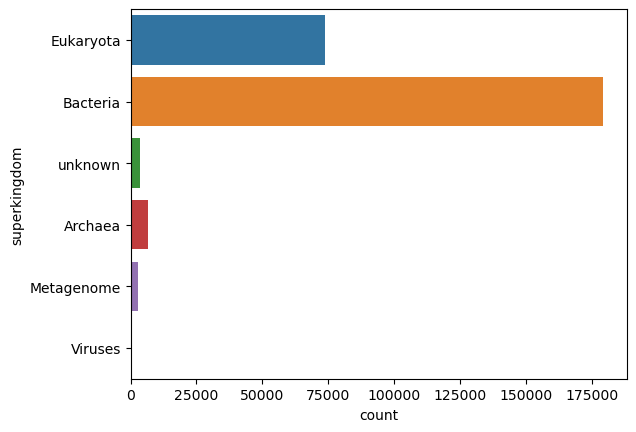

In [377]:
sns.countplot(y='superkingdom', data=anno_df2)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='kingdom'>

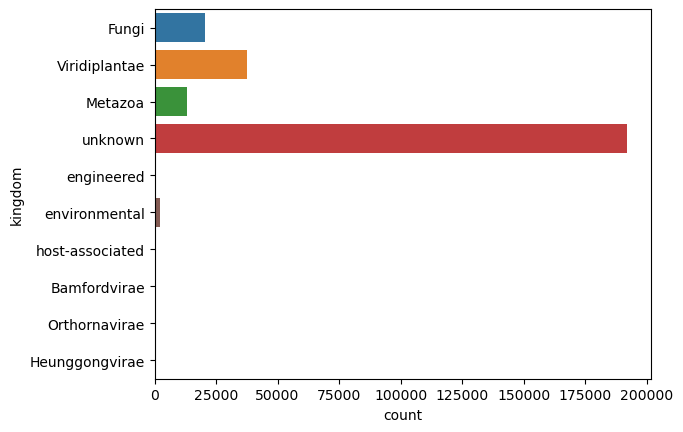

In [378]:
sns.countplot(y='kingdom', data=anno_df2)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='kingdom'>

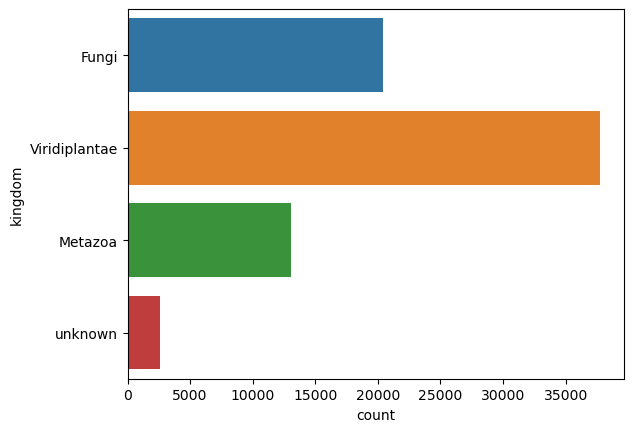

In [379]:
sns.countplot(y='kingdom', data=anno_df2[anno_df2['superkingdom'] == 'Eukaryota'])

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='phylum'>

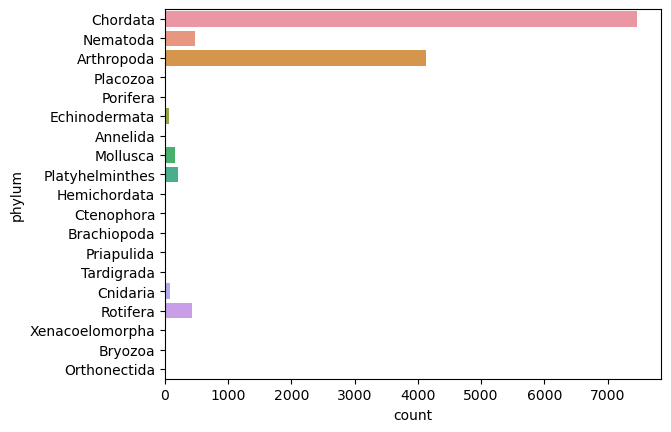

In [380]:
sns.countplot(y='phylum', data=anno_df2[(anno_df2['superkingdom'] == 'Eukaryota') & (anno_df2['kingdom'] == 'Metazoa')])

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='kingdom'>

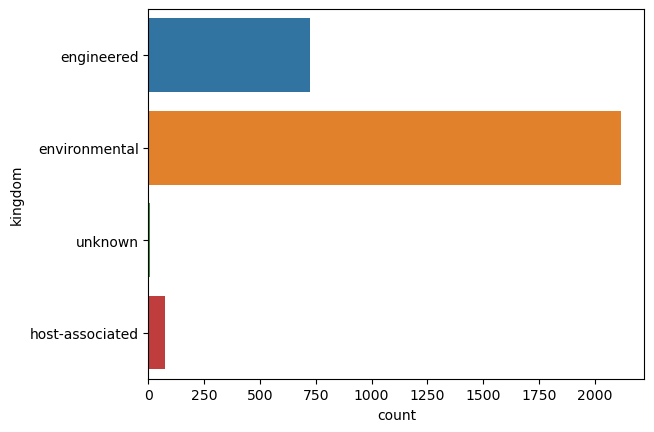

In [381]:
sns.countplot(y='kingdom', data=anno_df2[(anno_df2['superkingdom'] == 'Metagenome')])

In [382]:
anno_df2.to_csv('uniprot_mapping_annotated_lin_meta.csv')

In [385]:
anno_df2[['record_id', 'record_description', 'new_id', 'organism', 'tax_id', 'lineage', 'superkingdom', 'kingdom', 'phylum']].to_csv('uniprot_mapping_sele.csv')

## Add domains and architectures

In [386]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [387]:
anno_df = pd.read_csv('uniprot_mapping_sele.csv', index_col=0)

In [388]:
anno_df.shape


(266134, 9)

In [389]:
archs = pd.read_csv('../../uniprot_archs.csv', index_col=0)

C:\Users\terca\AppData\Local\Temp\ipykernel_12976\3210424072.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  archs = pd.read_csv('../../uniprot_archs.csv', index_col=0)


In [390]:
archs.shape

(220431, 19)

In [391]:
full_df = archs.merge(anno_df, how='left', left_on='id', right_on='new_id')

In [392]:
full_df.shape

(220431, 28)

In [393]:
full_df['superkingdom'].value_counts()/full_df.shape[0]*100

superkingdom
Bacteria      70.171618
Eukaryota     24.659871
Archaea        2.552273
unknown        1.430380
Metagenome     1.181322
Viruses        0.004537
Name: count, dtype: float64

In [394]:
pfam_cols = ['PF06330.14','PF01397.24', 'PF03936.19', 'PF00494.22', 'PF13249.9', 'PF19086.3','PF13243.9']
supfam_cols = ['0041184','0053354', '0053355', '0048261', '0048806', '0046340', '0047573']

In [395]:
full_df[pfam_cols].sum()/full_df.shape[0]*100

PF06330.14     2.128557
PF01397.24     9.697819
PF03936.19    17.438564
PF00494.22    14.408137
PF13249.9      5.701557
PF19086.3     21.676171
PF13243.9      5.875762
dtype: float64

In [396]:
full_df[supfam_cols].sum()/full_df.shape[0]*100

0041184     9.819399
0053354     9.811687
0053355    37.118191
0048261    27.766058
0048806    78.449038
0046340    84.649618
0047573    76.451134
dtype: float64

### Bacteria

In [399]:
bacteria = full_df[full_df['superkingdom']=='Bacteria']

In [402]:
bacteria['phylum'].value_counts()/bacteria.shape[0]*100

phylum
Actinomycetota                   35.246315
Pseudomonadota                   28.333980
Bacteroidota                      9.826093
Bacillota                         8.992759
Campylobacterota                  2.451513
                                   ...    
Candidatus Buchananbacteria       0.000646
Candidatus Fermentibacteria       0.000646
Candidatus Yanofskybacteria       0.000646
Candidatus Giovannonibacteria     0.000646
Candidatus Hydrothermae           0.000646
Name: count, Length: 134, dtype: float64

In [403]:
bacteria['architecture_pfam'].value_counts().head(10)/bacteria.shape[0]*100

architecture_pfam
['PF00494.22']                                  12.656452
['PF19086.3']                                    7.783812
['PF13249.9', 'PF13243.9']                       3.683734
['PF00494.22_partial']                           2.894363
['PF19086.3', 'PF19086.3']                       2.231704
['PF00494.22_partial', 'PF00494.22_partial']     0.579907
['PF13243.9_partial', 'PF13243.9_partial']       0.354926
['PF00494.22', 'PF00494.22_partial']             0.234678
['PF19086.3', 'PF19086.3_partial']               0.225627
['PF00494.22', 'PF00494.22']                     0.154513
Name: count, dtype: float64

In [404]:
bacteria['architecture_supfam'].value_counts().head(10)/bacteria.shape[0]*100

architecture_supfam
['0046340']                               70.536592
['0048806']                                4.379364
['0047573']                                3.433540
['0047573', '0047573']                     1.471425
['0047573', '0048806']                     0.539824
['0046340_partial']                        0.532066
['0046340_partial', '0046340']             0.423455
['0046340_partial', '0046340_partial']     0.357512
['0046340', '0046340']                     0.329713
['0047573_partial']                        0.320662
Name: count, dtype: float64

In [405]:
bacteria[pfam_cols].sum()/bacteria.shape[0]*100

PF06330.14     1.764934
PF01397.24     0.021981
PF03936.19     7.068141
PF00494.22    16.735195
PF13249.9      5.168089
PF19086.3     10.902508
PF13243.9      5.265063
dtype: float64

In [406]:
bacteria[supfam_cols].sum()/bacteria.shape[0]*100

0041184     0.033618
0053354     0.025213
0053355    28.132273
0048261    15.939359
0048806    76.172744
0046340    83.835661
0047573    74.736230
dtype: float64

### Eukaryota

In [407]:
eukaryota = full_df[full_df['superkingdom']=='Eukaryota']

In [409]:
eukaryota['kingdom'].value_counts()/eukaryota.shape[0]*100

kingdom
Viridiplantae    51.460687
Fungi            28.176165
Metazoa          16.777659
unknown           3.585489
Name: count, dtype: float64

#### Plantae

In [410]:
plantae = eukaryota[eukaryota['kingdom']=='Viridiplantae']

In [411]:
plantae['phylum'].value_counts()/plantae.shape[0]*100

phylum
Streptophyta         98.881064
Chlorophyta           1.101062
Prasinodermophyta     0.017874
Name: count, dtype: float64

In [412]:
plantae['architecture_pfam'].value_counts().head(10)/plantae.shape[0]*100

architecture_pfam
['PF01397.24', 'PF03936.19']                          51.921496
['PF01397.24_partial', 'PF03936.19']                   4.089658
['PF13249.9', 'PF13243.9']                             3.714296
['PF00494.22']                                         3.471204
['PF01397.24', 'PF03936.19_partial']                   3.317485
['PF03936.19']                                         2.938548
['PF01397.24', 'PF03936.19', 'PF03936.19_partial']     2.055554
['PF13243.9_partial', 'PF01397.24', 'PF03936.19']      1.740965
['PF01397.24', 'PF03936.19', 'PF19086.3_partial']      1.143960
['PF13249.9_partial', 'PF01397.24', 'PF03936.19']      1.126086
Name: count, dtype: float64

In [413]:
plantae['architecture_supfam'].value_counts().head(10)/plantae.shape[0]*100

architecture_supfam
['0048261']                       32.592142
['0053355']                       21.056018
['0046340']                       13.309263
['0041184', '0053355']             4.822507
['0041184', '0048261']             4.729561
['0053354', '0048261']             1.151110
['0053354', '0053355']             1.043864
['0053354', '0048806_partial']     0.961642
['0041184', '0053355_partial']     0.940192
['0053354', '0046340_partial']     0.754299
Name: count, dtype: float64

In [414]:
plantae[pfam_cols].sum()/plantae.shape[0]*100

PF06330.14     0.218067
PF01397.24    73.174132
PF03936.19    76.527366
PF00494.22     4.808208
PF13249.9      6.817288
PF19086.3     72.791620
PF13243.9      7.632360
dtype: float64

In [415]:
plantae[supfam_cols].sum()/plantae.shape[0]*100

0041184    74.017803
0053354    74.010653
0053355    76.616738
0048261    76.495192
0048806    87.134022
0046340    90.476531
0047573    87.720302
dtype: float64

#### Fungi

In [416]:
fungi = eukaryota[eukaryota['kingdom']=='Fungi']

In [417]:
fungi['phylum'].value_counts()/fungi.shape[0]*100

phylum
Ascomycota            70.018282
Basidiomycota         25.731261
Mucoromycota           3.277618
Zoopagomycota          0.385218
Chytridiomycota        0.359102
Blastocladiomycota     0.150170
Microsporidia          0.045704
unknown                0.026116
Cryptomycota           0.006529
Name: count, dtype: float64

In [418]:
fungi['architecture_pfam'].value_counts().head(10)/fungi.shape[0]*100

architecture_pfam
['PF19086.3']                                 33.957952
['PF00494.22']                                 8.644555
['PF06330.14']                                 7.410551
['PF19086.3', 'PF19086.3_partial']             4.302690
['PF13249.9', 'PF13243.9']                     3.649778
['PF19086.3_partial']                          2.892400
['PF19086.3_partial', 'PF19086.3']             1.508227
['PF19086.3_partial', 'PF19086.3_partial']     1.194829
['PF19086.3', 'PF19086.3']                     0.907548
['PF03936.19_partial', 'PF19086.3']            0.528859
Name: count, dtype: float64

In [419]:
fungi['architecture_supfam'].value_counts().head(10)/fungi.shape[0]*100

architecture_supfam
['0046340']                               33.971011
['0047573']                               24.092452
['0048806']                               15.545834
['0046340', '0046340']                     1.710629
['0047573', '0046340']                     1.710629
['0053355']                                1.442935
['0047573', '0048806']                     1.371115
['0046340_partial', '0046340_partial']     1.305824
['0046340_partial']                        1.025072
['0046340', '0048806']                     0.594150
Name: count, dtype: float64

In [421]:
fungi[pfam_cols].sum()/fungi.shape[0]*100

PF06330.14    12.065814
PF01397.24     0.006529
PF03936.19    29.531209
PF00494.22     9.525986
PF13249.9      4.061113
PF19086.3     53.460434
PF13243.9      3.943588
dtype: float64

In [422]:
fungi[supfam_cols].sum()/fungi.shape[0]*100

0041184     0.032646
0053354     0.013058
0053355    69.770175
0048261    68.314181
0048806    86.882998
0046340    87.607730
0047573    80.203709
dtype: float64

#### Metazoa

In [423]:
metazoa = eukaryota[eukaryota['kingdom']=='Metazoa']

In [424]:
metazoa['phylum'].value_counts()/metazoa.shape[0]*100

phylum
Chordata           51.557018
Arthropoda         36.885965
Nematoda            3.618421
Rotifera            3.081140
Platyhelminthes     1.842105
Mollusca            1.293860
Cnidaria            0.723684
Echinodermata       0.361842
Annelida            0.164474
Porifera            0.109649
Tardigrada          0.065789
Placozoa            0.054825
Hemichordata        0.043860
Priapulida          0.043860
Xenacoelomorpha     0.043860
Ctenophora          0.043860
Brachiopoda         0.032895
Bryozoa             0.021930
Orthonectida        0.010965
Name: count, dtype: float64

In [425]:
metazoa['architecture_pfam'].value_counts().head(10)/metazoa.shape[0]*100

architecture_pfam
['PF13249.9', 'PF13243.9']                         14.660088
['PF19086.3_partial']                               2.905702
['PF19086.3']                                       2.149123
['PF00494.22']                                      2.050439
['PF19086.3_partial', 'PF19086.3_partial']          1.359649
['PF03936.19_partial']                              0.548246
['PF13249.9', 'PF13243.9_partial', 'PF13243.9']     0.537281
['PF13249.9', 'PF13243.9_partial']                  0.526316
['PF01397.24', 'PF03936.19']                        0.526316
['PF19086.3', 'PF19086.3_partial']                  0.372807
Name: count, dtype: float64

In [426]:
metazoa['architecture_supfam'].value_counts().head(10)/metazoa.shape[0]*100

architecture_supfam
['0046340']                               59.429825
['0046340_partial']                       11.699561
['0046340_partial', '0046340']             1.600877
['0048806']                                1.250000
['0048806_partial', '0046340']             1.173246
['0047573']                                1.173246
['0046340_partial', '0046340_partial']     0.559211
['0046340', '0046340']                     0.548246
['0046340', '0047573_partial']             0.471491
['0046340', '0048806_partial']             0.361842
Name: count, dtype: float64

In [427]:
metazoa[pfam_cols].sum()/metazoa.shape[0]*100

PF06330.14     0.087719
PF01397.24     0.592105
PF03936.19     2.763158
PF00494.22     2.642544
PF13249.9     16.940789
PF19086.3      8.092105
PF13243.9     16.973684
dtype: float64

In [428]:
metazoa[supfam_cols].sum()/metazoa.shape[0]*100

0041184     0.603070
0053354     0.635965
0053355    25.208333
0048261    23.640351
0048806    79.517544
0046340    81.217105
0047573    68.541667
dtype: float64

### Archaea

In [429]:
archae = full_df[full_df['superkingdom']=='Archaea']

In [430]:
archae['phylum'].value_counts()/archae.shape[0]*100

phylum
Euryarchaeota                     59.847138
Candidatus Thermoplasmatota       12.335585
Candidatus Bathyarchaeota          6.238891
Thermoproteota                     5.599005
Nitrososphaerota                   5.207963
unknown                            1.990757
Candidatus Micrarchaeota           1.261998
Candidatus Lokiarchaeota           1.208674
Candidatus Aenigmarchaeota         1.066477
Candidatus Thorarchaeota           0.942055
Candidatus Woesearchaeota          0.799858
Candidatus Altiarchaeota           0.533239
Candidatus Hadarchaeota            0.479915
Candidatus Heimdallarchaeota       0.444365
Candidatus Diapherotrites          0.408816
Candidatus Verstraetearchaeota     0.408816
Candidatus Korarchaeota            0.337718
Nanoarchaeota                      0.302169
Candidatus Undinarchaeota          0.124422
Candidatus Helarchaeota            0.106648
Candidatus Geothermarchaeota       0.088873
Candidatus Marsarchaeota           0.088873
Candidatus Hydrothermarch

In [431]:
archae['architecture_pfam'].value_counts().head(10)/archae.shape[0]*100

architecture_pfam
['PF00494.22']                                  25.311056
['PF03936.19_partial']                           1.635265
['PF19086.3']                                    1.439744
['PF00494.22_partial', 'PF00494.22_partial']     0.906506
['PF00494.22_partial']                           0.764309
['PF19086.3_partial']                            0.622112
['PF13243.9_partial', 'PF13243.9_partial']       0.586562
['PF00494.22_partial', 'PF00494.22']             0.497689
['PF03936.19_partial', 'PF03936.19_partial']     0.302169
['PF13243.9_partial']                            0.302169
Name: count, dtype: float64

In [432]:
archae['architecture_supfam'].value_counts().head(10)/archae.shape[0]*100

architecture_supfam
['0046340']                       63.544259
['0047573_partial', '0046340']     3.697121
['0046340_partial']                3.252755
['0048806_partial', '0046340']     2.843939
['0048261_partial']                0.817632
['0047573_partial']                0.728759
['0053355_partial']                0.710985
['0048261']                        0.622112
['0046340', '0047573_partial']     0.551013
['0046340', '0048806_partial']     0.533239
Name: count, dtype: float64

In [433]:
archae[pfam_cols].sum()/archae.shape[0]*100

PF06330.14     0.000000
PF01397.24     0.035549
PF03936.19     3.430501
PF00494.22    28.101671
PF13249.9      2.310700
PF19086.3      4.852471
PF13243.9      2.328475
dtype: float64

In [434]:
archae[supfam_cols].sum()/archae.shape[0]*100

0041184     0.053324
0053354     0.035549
0053355    25.844294
0048261    13.099893
0048806    72.467117
0046340    76.768574
0047573    71.098471
dtype: float64

### Metagenome

In [435]:
metagenome = full_df[full_df['superkingdom']=='Metagenome']

In [436]:
metagenome['kingdom'].value_counts()/metagenome.shape[0]*100

kingdom
environmental      73.003072
engineered         24.500768
host-associated     2.265745
unknown             0.230415
Name: count, dtype: float64

In [437]:
metagenome['architecture_pfam'].value_counts().head(10)/metagenome.shape[0]*100

architecture_pfam
['PF01397.24', 'PF03936.19']                         17.857143
['PF00494.22']                                        9.715822
['PF13249.9', 'PF13243.9']                            2.611367
['PF00494.22_partial']                                1.958525
['PF19086.3_partial']                                 0.960061
['PF19086.3']                                         0.576037
['PF00494.22_partial', 'PF00494.22_partial']          0.576037
['PF03936.19_partial', 'PF03936.19_partial']          0.576037
['PF13243.9_partial', 'PF01397.24', 'PF03936.19']     0.307220
['PF03936.19_partial']                                0.192012
Name: count, dtype: float64

In [438]:
metagenome['architecture_supfam'].value_counts().head(10)/metagenome.shape[0]*100

architecture_supfam
['0046340']                       64.285714
['0053355']                       10.637481
['0048261']                        6.605223
['0046340_partial']                0.883257
['0041184', '0053355']             0.576037
['0046340', '0048806_partial']     0.499232
['0047573']                        0.422427
['0046340', '0046340']             0.384025
['0048806']                        0.345622
['0048806_partial', '0046340']     0.345622
Name: count, dtype: float64

In [439]:
metagenome[pfam_cols].sum()/metagenome.shape[0]*100

PF06330.14     0.230415
PF01397.24    18.778802
PF03936.19    20.967742
PF00494.22    12.480799
PF13249.9      3.609831
PF19086.3     20.545315
PF13243.9      3.917051
dtype: float64

In [440]:
metagenome[supfam_cols].sum()/metagenome.shape[0]*100

0041184    18.778802
0053354    18.778802
0053355    33.832565
0048261    24.423963
0048806    83.448541
0046340    87.519201
0047573    82.334869
dtype: float64

### Viruses

In [441]:
viruses = full_df[full_df['superkingdom']=='Viruses']

In [443]:
viruses['architecture_pfam'].value_counts().head(10)/viruses.shape[0]*100

architecture_pfam
['PF19086.3']     10.0
['PF00494.22']    10.0
Name: count, dtype: float64

In [444]:
viruses['architecture_supfam'].value_counts().head(10)/viruses.shape[0]*100

architecture_supfam
['0046340']    80.0
['0047573']    10.0
Name: count, dtype: float64

In [446]:
viruses[pfam_cols].sum()/viruses.shape[0]*100

PF06330.14     0.0
PF01397.24     0.0
PF03936.19     0.0
PF00494.22    10.0
PF13249.9      0.0
PF19086.3     10.0
PF13243.9      0.0
dtype: float64

In [445]:
viruses[supfam_cols].sum()/viruses.shape[0]*100

0041184     0.0
0053354     0.0
0053355    70.0
0048261    20.0
0048806    80.0
0046340    90.0
0047573    80.0
dtype: float64

In [398]:
full_df.to_csv('../../uniprot_annotation.csv')